In [88]:
import numpy as np
import pandas as pd
import networkx as nx

# Handling Networks

### Let's continue our exploration of the show Big Bang Theory with a focus on it's graph structure!

First, load the data that we prepared for you the data in a nice format:

In [89]:
lines = pd.read_pickle("data/BBT_lines.pkl")
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


And let's define the characters that we are interested to study:

In [90]:
recurrent_characters = ['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily', 'Howard', 
                       'Leonard', 'Leslie', 'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart', 'Wil', 
                       'Zack', 'Lucy', 'Kripke', 'Isabella']

## The Gossip Graph

Let us define _gossip_ as follows: if a dialogue line of character A mentions B by name in a scene that does not involve character B, we say that “A gossips about B” in that line. Multiple mentions of the same person in a single line are counted once, but a character can gossip about several others in the same line. For the sake of simplicity, we only consider gossips where the name of the recurrent character is mentioned as it appears in our list of characters; for example, if someone says "Cooper" and they mean Sheldon, we discard that.

Create the two following graphs first:

1. Create the _familiarity graph_, an undirected weighted graph, in which there is a node for each recurrent character, and an edge between two characters if they appear together in at least one scene. The weight of the edge between them is the number of scenes they appear in together. If an edge exists between two people in the familiarity graph, we say that they "know each other".
2. Create the _gossip graph_, which is a directed weighted graph, in which there there is a node for each recurrent character, and a directed edge from the node for A to the node for B if A has gossiped about B at least once. The weight of the edge is the number of scenes in which A has gossiped about B.

Visualise both graphs.

In [91]:
import nltk
import spacy

In [92]:
nlp = spacy.load('en')

In [93]:
lines_main = lines[lines['Character'].isin(recurrent_characters)]

In [94]:
scene_interactions = pd.DataFrame(lines_main.groupby(['Season','Episode','Scene'])['Character'].unique()).reset_index(drop=False)
scene_interactions['Character'] = scene_interactions['Character'].apply(set)

In [95]:
lines_extra= lines_main.merge(scene_interactions, on=['Season','Episode','Scene'])

In [96]:
import re
import matplotlib.pyplot as plt

In [97]:
def tokenize(data):
    tokens = re.split("[^a-zA-Z]+", data)
    return set(tokens)

lines_extra['Line_token'] = lines_extra['Line'].apply(tokenize)

In [98]:
lines_extra.head()

,Season,Episode,Scene,Character_x,Line,Character_y,Line_token
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...,"{Leonard, Sheldon}","{, left, but, plane, is, its, two, the, a, thr..."
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?","{Leonard, Sheldon}","{, point, s, Agreed, your, what}"
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide...","{Leonard, Sheldon}","{, I, good, idea, tee, a, point, There, s, jus..."
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?,"{Leonard, Sheldon}","{, me, Excuse}"
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"One across is Aegean, eight down is Nabakov, t...","{Leonard, Sheldon}","{, Haiti, your, fourteen, phylum, is, six, whi..."


In [99]:
def get_gossip(scene):
    gossip = []
    for idx, row in scene.iterrows():
        for word in row['Line_token']:
            if (word in recurrent_characters) & (word not in row['Character_y']):
                gossip.append({'Character': row['Character_x'], 'Mentions': word})
    return gossip
            
gm = lines_extra.groupby(['Season','Episode','Scene']).apply(get_gossip).reset_index(drop=True)

In [100]:
de_list = []
for idx, row in gm.iteritems():
    for item in row:
        de_list.append(item)

In [101]:
gossip = pd.DataFrame(pd.DataFrame(de_list).value_counts()).reset_index(drop=False).rename({0:'count'},axis=1)

In [102]:
gossip_graph = nx.DiGraph()

for idx, r in gossip.iterrows():
    gossip_graph.add_edge(r["Character"], r["Mentions"], weight=r["count"])

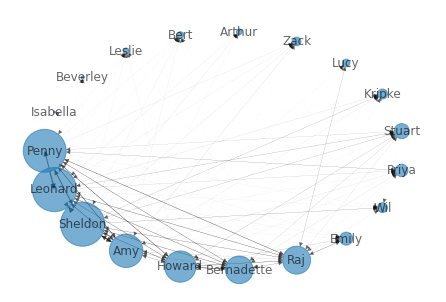

In [103]:
edges = gossip_graph.edges()
weights = [0.01*gossip_graph[u][v]['weight'] for u,v in edges]
weighted_degree = dict(gossip_graph.degree(weight='weight'))

nx.draw_shell(gossip_graph, with_labels=True, alpha = 0.6, width=weights, node_size=[v * 3 for v in weighted_degree.values()])

In [104]:
df = pd.DataFrame(recurrent_characters, columns = ['Name1'])
cartesian_df = df.assign(foo=1).merge(df.assign(foo=1), on = 'foo').drop(['foo'], axis=1)
cartesian_df = cartesian_df[~(cartesian_df['Name1_x'] == cartesian_df['Name1_y'])]

In [105]:
cartesian_df['count'] = 0

In [106]:
def count_people(p1, p2, count, df):
    for character in df['Character']:
        if (p1 in character) and (p2 in character):
            count += 1
    return count


In [107]:
cartesian_df['new_count'] = cartesian_df.apply(lambda x: count_people(x['Name1_x'],x['Name1_y'], x['count'], scene_interactions), axis=1)

In [108]:
bigbangG =nx.from_pandas_edgelist(cartesian_df, 'Name1_x', 'Name1_y', edge_attr='new_count', create_using= nx.Graph())

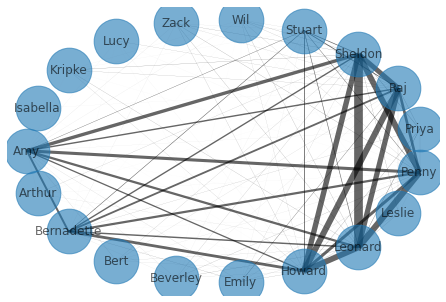

In [109]:
edges = bigbangG.edges()
weights = [0.01*bigbangG[u][v]['new_count'] for u,v in edges]

nx.draw_shell(bigbangG, with_labels=True, alpha = 0.6, node_size=2000, width=weights)

In [110]:
cartesian_df = cartesian_df.drop(['count'], axis=1)

Now, answer the following questions:

**Q1: Who is the most mentioned person?**

In [111]:
import collections

In [112]:
gossip_graph.in_degree(weight='weight')

InDegreeView({'Penny': 259, 'Leonard': 332, 'Sheldon': 211, 'Amy': 205, 'Howard': 163, 'Bernadette': 154, 'Raj': 112, 'Emily': 54, 'Wil': 33, 'Priya': 44, 'Stuart': 56, 'Kripke': 33, 'Lucy': 18, 'Zack': 24, 'Arthur': 9, 'Bert': 14, 'Leslie': 10, 'Beverley': 2, 'Isabella': 1})

In [113]:
collections.Counter(dict(gossip_graph.in_degree(weight='weight')))

Counter({'Penny': 259,
         'Leonard': 332,
         'Sheldon': 211,
         'Amy': 205,
         'Howard': 163,
         'Bernadette': 154,
         'Raj': 112,
         'Emily': 54,
         'Wil': 33,
         'Priya': 44,
         'Stuart': 56,
         'Kripke': 33,
         'Lucy': 18,
         'Zack': 24,
         'Arthur': 9,
         'Bert': 14,
         'Leslie': 10,
         'Beverley': 2,
         'Isabella': 1})

In [114]:
weighted_degree = collections.Counter(dict(gossip_graph.in_degree(weight='weight')))
weighted_degree.most_common()[0]

('Leonard', 332)

**Q2: Sheldon claims that every character in the show is familiar with everyone else through at most one intermediary. Based on the familiarity graph, is this true? If not, at most how many intermediaries are needed?**

In [121]:
nodes = list(bigbangG.nodes())

In [122]:
nodes

['Amy',
 'Arthur',
 'Bernadette',
 'Bert',
 'Beverley',
 'Emily',
 'Howard',
 'Leonard',
 'Leslie',
 'Penny',
 'Priya',
 'Raj',
 'Sheldon',
 'Stuart',
 'Wil',
 'Zack',
 'Lucy',
 'Kripke',
 'Isabella']

In [126]:
length = []
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        length.append({'Node1': nodes[i], 'Node2': nodes[j], 'Shortest':nx.shortest_path_length(bigbangG, source=nodes[i], target=nodes[j])})
        
length

[{'Node1': 'Amy', 'Node2': 'Arthur', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Bernadette', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Bert', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Beverley', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Emily', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Howard', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Leonard', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Leslie', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Penny', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Priya', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Raj', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Sheldon', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Stuart', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Wil', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Zack', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Lucy', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Kripke', 'Shortest': 1},
 {'Node1': 'Amy', 'Node2': 'Isabella', 'Shortest': 1},
 {'Node1': 'Arthur', 'Node2': 'Bernadette', 'Shorte

**Q3. Who is the character through whom the largest number of these indirect familiarities happen? Calculate an appropriate centrality metric on the familiarity graph to answer this question.**

In [128]:
most_central_people = sorted(nx.betweenness_centrality(bigbangG).items(), key=lambda r: -r[1])
most_central_people[:5]

[('Amy', 0.0),
 ('Arthur', 0.0),
 ('Bernadette', 0.0),
 ('Bert', 0.0),
 ('Beverley', 0.0)]

**Q4. Another claim of Sheldon's is that every recurrent character in the show gossips about all the other recurrent characters. (A) Does the gossip graph possess that property?**

**Q5. Use the gossip graph and the familiarity graph to figure out if for every pair of recurrent characters, one of them has gossiped about the other if and only if they know each other (shared a scene).**

## Quiz

**Quiz A: Given the following adjacency matrix of a graph:**

<img src="imgs/quizA.png">

1. A is a directed graph with average in-degree 4/3
2. A is an undirected graph with average degree 4/3
3. A is a directed graph with average in-degree 1
4. A is an undirected graph with average degree 1

**Quiz B: In a horror scenario, your lost luggage is landing at an airport and being loaded to another random flight and transferred to another airport. This has been going on for months. Given a very large number of iterations, which of the following metrics gives you the probability that your luggage ends up in Geneva airport?**

1. Closeness centrality
2. Page rank
3. Betweenness centrality
4. Katz similarity